[INFO] ============================================================
[INFO] AUTOREGRESSIVE CHEMICAL EVOLUTION (Δt-chunked)
[INFO] ============================================================
[INFO] Loading normalization...
[INFO] Species count: 12
[INFO] Global variables: ['P', 'T']
[INFO] Training Δt range (physical): [1.000e-03, 1.000e+08]
[INFO] Loading model...
[INFO] Model loaded from: /Users/imalsky/Desktop/Chemulator/models/v4_2/export_k1_cpu.pt2
[INFO] Loading VULCAN from: /Users/imalsky/Desktop/Chemistry_Project/Vulcan/0D_full_NCHO/solar/vul-T1000KlogP3.0-NCHO-solar_hot_ini.vul
[INFO] VULCAN data loaded: 743 timesteps, 69 species
[INFO] VULCAN time range: 0.00e+00 to 4.21e+19 seconds
[INFO] Sampling VULCAN at t=1.000e-02s (actual: 1.137e-02s)
[INFO] Initial sum (physical): 1.000000
[INFO] Generated 100 coarse steps: min Δt=3.183e-03, max Δt=2.414e+09
[INFO] Step    5/100: substeps=1; top: H2: 9.966e-01, NH3: 3.255e-03, CH4: 1.391e-04
[INFO] Step   10/100: substeps=1; top: H2: 9

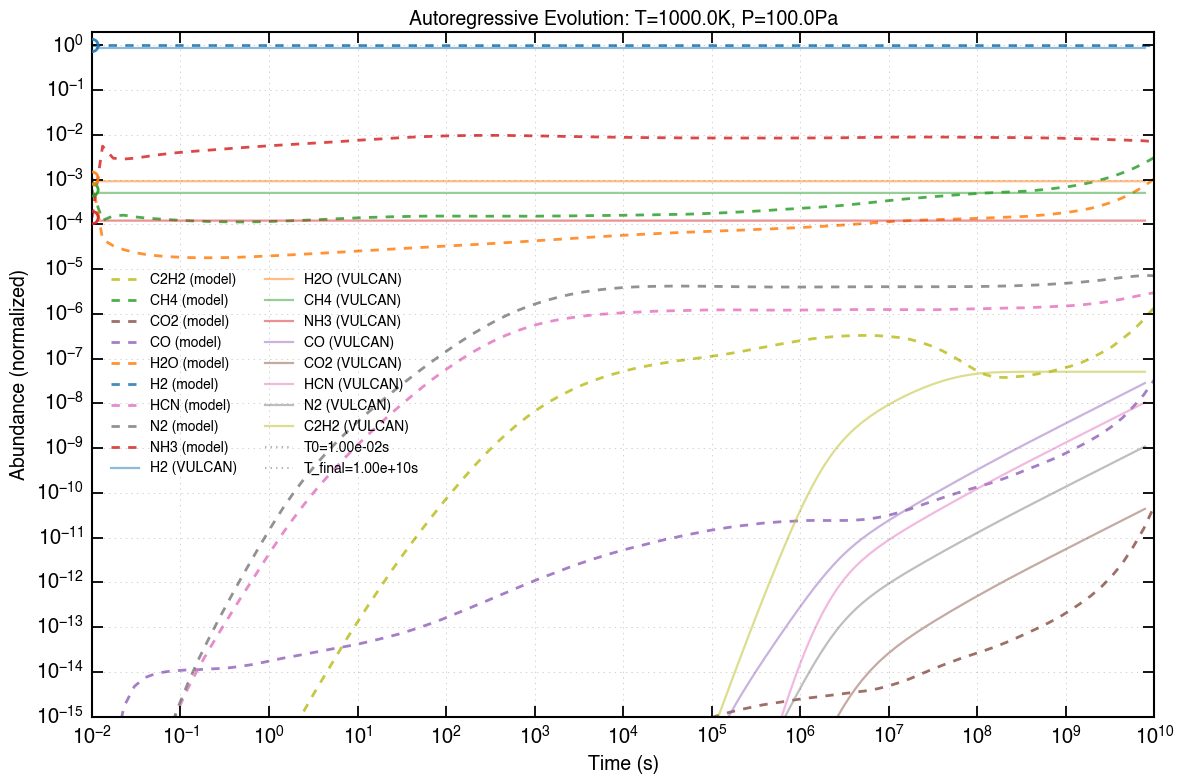

[INFO] Plot complete
[INFO] ============================================================
[INFO] COMPLETE


In [24]:
#!/usr/bin/env python3
"""
Autoregressive chemical evolution with Δt chunking and apples-to-apples plotting.

Fixes & features:
- Uses norm.normalize_dt_from_phys() (no manual Δt math).
- Splits any Δt > dt_max_phys into substeps so every model call stays in-range.
- No external simplex projection each step (softmax head should handle normalization).
- Chooses pressure units (barye/Pa/bar/atm) to match training stats automatically.
- Plots VULCAN curves normalized over the SAME tracked-species subset as the model.

You said: "pressure is in CGS units when fed into VULCAN". We still detect what
units the model was TRAINED on and pass globals accordingly, so the model sees
the right scale even if VULCAN uses CGS internally.
"""

import math
import json
import sys
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

# ==================== USER CONFIGURATION ====================

# Time configuration (your requested values)
T0 = 1e5
T_FINAL = 1.0e10
N_COARSE_STEPS = 6

# Plot limits
XLIM = (T0, T_FINAL)
YLIM = (1e-15, 2)

# Small abundance floor (for numeric stability when plotting/logging only)
PLOT_FLOOR = 1e-30

# Physical conditions (YOUR experiment setup)
T_K = 1000.0         # Kelvin
P_Pa = 100.0         # Pascals (VULCAN internally uses CGS, but model may not)

# Species to plot (others will be computed but not shown)
PLOT_SPECIES = ['H2', 'H2O', 'CH4', 'NH3', 'CO', 'CO2', 'HCN', 'N2', 'C2H2']

# Paths
REPO_ROOT = Path("/Users/imalsky/Desktop/Chemulator")
MODEL_DIR = REPO_ROOT / "models" / "v4_2"
PROCESSED_DIR = REPO_ROOT / "data" / "processed"
SRC_DIR = REPO_ROOT / "src"
VULCAN_PATH = Path("/Users/imalsky/Desktop/Chemistry_Project/Vulcan/0D_full_NCHO/solar/vul-T1000KlogP3.0-NCHO-solar_hot_ini.vul")

# ==================== END CONFIGURATION ====================

# Add source directory to path
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))
from normalizer import NormalizationHelper  # noqa: E402

# Matplotlib style
try:
    plt.style.use('science.mplstyle')
except Exception:
    pass


# ----------------------------- Utilities -------------------------------------

def debug_print(msg: str, level: str = "INFO"):
    print(f"[{level}] {msg}")


def load_vulcan_data(path: Path) -> Dict:
    """Load VULCAN pickle file and return time, mixing ratios, and species names."""
    debug_print(f"Loading VULCAN from: {path}")
    if not path.exists():
        raise FileNotFoundError(f"VULCAN file not found: {path}")

    with open(path, "rb") as h:
        d = pickle.load(h)

    t = np.asarray(d["variable"]["t_time"], dtype=float)        # [M]
    Y = np.asarray(d["variable"]["y_time"], dtype=float)        # [M, 1, S]
    names = list(d["variable"]["species"])                      # [S]

    den = np.maximum(Y[:, 0, :].sum(axis=-1), 1e-30)
    MR = Y[:, 0, :] / den[:, None]                              # [M, S]

    debug_print(f"VULCAN data loaded: {len(t)} timesteps, {len(names)} species")
    debug_print(f"VULCAN time range: {t[0]:.2e} to {t[-1]:.2e} seconds")

    return {"t": t, "MR": MR, "names": names}


def get_initial_abundances(vul: Dict, t_target: float, species_list: List[str]) -> np.ndarray:
    """Nearest-neighbor sample of VULCAN abundances at t_target for the requested species."""
    t = vul["t"]
    idx = int(np.argmin(np.abs(t - t_target)))
    t_actual = float(t[idx])
    debug_print(f"Sampling VULCAN at t={t_target:.3e}s (actual: {t_actual:.3e}s)")

    MR = vul["MR"]
    names = vul["names"]

    out = np.zeros(len(species_list), dtype=np.float64)
    for i, s in enumerate(species_list):
        s_base = s.replace("_evolution", "")
        if s_base in names:
            j = names.index(s_base)
            out[i] = float(MR[idx, j])
        else:
            out[i] = 0.0  # absent species start at zero; decoder/softmax handles normalization

    # Normalize to simplex once at initialization
    denom = out.sum()
    if denom <= 0 or not np.isfinite(denom):
        out[:] = 1.0 / len(out)
    else:
        out /= denom
    return out


def generate_coarse_grid(t_start: float, t_end: float, n_steps: int) -> Tuple[np.ndarray, np.ndarray]:
    """Log-spaced coarse times and the corresponding Δt array."""
    times = np.logspace(np.log10(t_start), np.log10(t_end), n_steps + 1)
    dt_array = np.diff(times)  # length n_steps
    return times, dt_array


def chunk_dt(dt_phys: float, dt_max: float) -> List[float]:
    """Split a physical Δt into substeps each ≤ dt_max."""
    if dt_phys <= dt_max:
        return [float(dt_phys)]
    n = int(math.ceil(dt_phys / dt_max))
    step = dt_phys / n
    return [float(step)] * n


# ---- Global variables normalization (auto-select P units to match training) --

def choose_pressure_units_for_training(P_pa: float, norm: NormalizationHelper) -> Tuple[str, float, float]:
    """
    Try several unit conventions for P and pick the one whose normalized value sits away
    from the [0,1] edges under the model's log-min-max training stats.
    Returns (unit_name, P_phys_chosen, normalized_scalar).
    """
    manifest = getattr(norm, "manifest", {})
    stats = manifest.get("stats", {})
    p_stats = stats.get("P", {})
    p_min = p_stats.get("min", None)
    p_max = p_stats.get("max", None)

    # If we don't have stats, default to barye (CGS)
    if p_min is None or p_max is None:
        P_barye = P_pa * 10.0
        z = float(norm.normalize(torch.tensor([[P_barye]], dtype=torch.float32), ["P"]).item())
        return ("barye(default)", P_barye, z)

    candidates = [
        ("Pa",      P_pa),
        ("bar",     P_pa / 1.0e5),     # 1 bar = 1e5 Pa
        ("atm",     P_pa / 1.01325e5), # 1 atm = 1.01325e5 Pa
        ("barye",   P_pa * 10.0),      # 1 Pa = 10 barye
    ]

    # Score: prefer normalized P in [0.05,0.95], penalize distance to 0.5
    best = None
    for name, P_phys in candidates:
        z = float(norm.normalize(torch.tensor([[P_phys]], dtype=torch.float32), ["P"]).item())
        # clamp score if outside [0,1]
        if not np.isfinite(z):
            score = float("inf")
        else:
            # penalty if outside [0,1]
            if z < 0.0: edge_pen = (0.0 - z) * 10.0
            elif z > 1.0: edge_pen = (z - 1.0) * 10.0
            else: edge_pen = 0.0
            score = abs(z - 0.5) + edge_pen
        if (best is None) or (score < best[0]):
            best = (score, name, P_phys, z)

    _, unit_name, P_chosen, z_best = best
    return (unit_name, P_chosen, z_best)


def build_globals_tensor(norm: NormalizationHelper,
                         global_vars: List[str],
                         T_K: float,
                         P_pa: float) -> torch.Tensor:
    """
    Build and normalize the globals tensor [1, G], auto-choosing P units to match training.
    """
    # Pick P units that place normalized P away from edges
    unit_name, P_phys, z_val = choose_pressure_units_for_training(P_pa, norm)

    g_phys = np.zeros((1, len(global_vars)), dtype=np.float32)
    for i, name in enumerate(global_vars):
        if name.lower() == 'p':
            g_phys[0, i] = P_phys
        elif name.lower() == 't':
            g_phys[0, i] = T_K
        else:
            # Fallback if names are not clean 'P'/'T'
            if 'p' in name.lower():
                g_phys[0, i] = P_phys
            elif 't' in name.lower():
                g_phys[0, i] = T_K

    g_z = norm.normalize(torch.from_numpy(g_phys), global_vars).float()

    debug_print(f"Globals: P input={P_pa:.3e} Pa; chosen units={unit_name}; "
                f"P_phys={g_phys[0, list(map(str.lower, global_vars)).index('p')]:.3e}; "
                f"normalized P≈{z_val:.3f}")
    debug_print(f"Globals normalized tensor: {g_z.numpy()}")
    return g_z


# --------------------------- Autoregressive loop -----------------------------

@torch.inference_mode()
def run_autoregressive_evolution(model,
                                 norm: NormalizationHelper,
                                 y0_phys: np.ndarray,
                                 dt_array: np.ndarray,
                                 species_names: List[str],
                                 global_vars: List[str],
                                 dt_min_phys: float,
                                 dt_max_phys: float,
                                 T_K: float,
                                 P_pa: float):
    """
    Autoregress in z-space; denormalize only for logging/storage.
    Ensures every model call uses Δt within [dt_min_phys, dt_max_phys] by splitting large steps.
    """
    device = torch.device("cpu")
    dtype = torch.float32

    # Prepare globals (auto-units)
    g_z = build_globals_tensor(norm, global_vars, T_K=T_K, P_pa=P_pa).to(device, dtype)

    # Initial state: physical -> z
    y_z = norm.normalize(torch.from_numpy(y0_phys[None, :]).to(dtype), species_names).to(device, dtype)  # [1, S]

    n_coarse = len(dt_array)
    n_species = len(species_names)

    # Storage (physical space) at coarse checkpoints
    evolution = np.zeros((n_coarse + 1, n_species), dtype=np.float64)
    evolution[0, :] = np.maximum(y0_phys, PLOT_FLOOR)

    # Instrumentation
    big_steps = 0
    total_substeps = 0

    # March
    for k, dt_phys in enumerate(dt_array, start=1):
        subs = chunk_dt(float(dt_phys), dt_max_phys)
        if len(subs) > 1:
            big_steps += 1
        total_substeps += len(subs)

        for s in subs:
            dt_norm = norm.normalize_dt_from_phys(torch.tensor([s], dtype=dtype))  # [1]
            dt_norm = dt_norm.view(1, 1, 1)                                        # [1,1,1]
            y_z = model(y_z, dt_norm, g_z)                                         # [1,S] or [1,1,S]
            if y_z.dim() == 3:
                y_z = y_z.squeeze(1)

        y_phys = norm.denormalize(y_z, species_names).cpu().numpy().reshape(-1)
        y_phys = np.maximum(y_phys, PLOT_FLOOR)
        evolution[k, :] = y_phys

        if (k % max(1, n_coarse // 20) == 0) or (k == n_coarse):
            top_idx = np.argsort(evolution[k, :])[-3:][::-1]
            debug_print(f"Step {k:4d}/{n_coarse}: substeps={len(subs)}; "
                        f"top: " + ", ".join(f"{species_names[i].replace('_evolution','')}: {evolution[k,i]:.3e}"
                                             for i in top_idx))

    debug_print(f"Coarse steps needing chunking: {big_steps}/{n_coarse}")
    debug_print(f"Total model calls (substeps): {total_substeps}")

    return evolution


# ------------------------------- Plotting ------------------------------------

def plot_results(times: np.ndarray,
                 evolution: np.ndarray,
                 species_names: List[str],
                 vul_data: Dict):
    """
    Plot coarse-checkpoint evolution (physical space) and overlay VULCAN references.
    VULCAN curves are normalized by the sum over the SAME tracked species subset.
    """
    debug_print("Creating plot...")

    tracked = [s.replace("_evolution", "") for s in species_names]
    name_to_idx_vul = {n: i for i, n in enumerate(vul_data["names"]) if n in tracked}
    tracked_idx = [name_to_idx_vul[s] for s in tracked if s in name_to_idx_vul]

    # Normalize model rows for plotting clarity (guard divide-by-zero)
    sums = np.maximum(evolution.sum(axis=1, keepdims=True), PLOT_FLOOR)
    evolution_norm = evolution / sums

    fig, ax = plt.subplots(figsize=(12, 8))

    # Color mapping
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    color_map = {sp: colors[i % 10] for i, sp in enumerate(PLOT_SPECIES)}

    # Model evolution
    for j, name in enumerate(species_names):
        sp = name.replace("_evolution", "")
        if sp in PLOT_SPECIES:
            y_plot = np.maximum(evolution_norm[:, j], PLOT_FLOOR)
            ax.loglog(times, y_plot, '--', lw=2,
                      color=color_map[sp], alpha=0.85, label=f'{sp} (model)')
            ax.scatter(times[0], y_plot[0], s=80,
                       facecolors='none', edgecolors=color_map[sp],
                       linewidth=2, alpha=0.9, zorder=5)

    # VULCAN reference normalized over the *tracked subset only*
    if len(tracked_idx) > 0:
        vul_t = vul_data["t"]
        vul_MR = vul_data["MR"]
        vul_tracked_sum = np.maximum(vul_MR[:, tracked_idx].sum(axis=1, keepdims=True), PLOT_FLOOR)
        for sp in PLOT_SPECIES:
            if sp in name_to_idx_vul:
                j = name_to_idx_vul[sp]
                vul_abun = np.maximum(vul_MR[:, j] / vul_tracked_sum[:, 0], PLOT_FLOOR)
                mask = (vul_t >= XLIM[0]) & (vul_t <= XLIM[1])
                if mask.any():
                    ax.loglog(vul_t[mask], vul_abun[mask], '-', lw=1.6,
                              color=color_map[sp], alpha=0.5, label=f'{sp} (VULCAN)')

    ax.set_xlabel("Time (s)", fontsize=14)
    ax.set_ylabel("Abundance (normalized)", fontsize=14)
    ax.set_xlim(XLIM)
    ax.set_ylim(YLIM)
    ax.grid(True, which='both', alpha=0.25)

    # Deduplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), loc='best', fontsize=10, ncol=2)

    ax.set_title(f"Autoregressive Evolution: T={T_K}K, P={P_Pa}Pa", fontsize=14)
    plt.tight_layout()
    plt.show()
    debug_print("Plot complete")


# --------------------------------- Main --------------------------------------

def main():
    debug_print("=" * 60)
    debug_print("AUTOREGRESSIVE CHEMICAL EVOLUTION (Δt-chunked, unit-checked)")
    debug_print("=" * 60)

    torch.set_num_threads(1)

    # Load normalization manifest and helper
    debug_print("Loading normalization...")
    norm_path = PROCESSED_DIR / "normalization.json"
    with open(norm_path, "r") as f:
        norm_manifest = json.load(f)
    norm = NormalizationHelper(norm_manifest)

    meta = norm_manifest.get("meta", {})
    species_vars = list(meta.get("species_variables", []))      # names as used in training (likely *_evolution)
    species_bases = [n.replace("_evolution", "") for n in species_vars]
    global_vars = list(meta.get("global_variables", []))

    debug_print(f"Species count: {len(species_vars)}")
    debug_print(f"Global variables: {global_vars}")

    # Δt stats (physical range learned during training)
    dt_stats = norm_manifest.get("stats", {}).get("dt", {})
    dt_min_phys = float(dt_stats.get("min", 1e-3))
    dt_max_phys = float(dt_stats.get("max", 1e+8))
    debug_print(f"Training Δt range (physical): [{dt_min_phys:.3e}, {dt_max_phys:.3e}]")

    # Load exported model
    debug_print("Loading model...")
    model_path = None
    for name in ["export_k1_cpu.pt2", "export_k1.pt2", "complete_model_exported_k1.pt2"]:
        p = MODEL_DIR / name
        if p.exists():
            model_path = p
            break
    if model_path is None:
        raise FileNotFoundError(f"No exported model found in {MODEL_DIR}")

    from torch.export import load as torch_export_load
    exported = torch_export_load(str(model_path))
    model = exported.module()
    debug_print(f"Model loaded from: {model_path}")

    # Load VULCAN data and seed initial abundances at T0
    vul_data = load_vulcan_data(VULCAN_PATH)
    y0_phys = get_initial_abundances(vul_data, T0, species_vars)  # physical simplex at t=T0
    debug_print(f"Initial sum (physical): {y0_phys.sum():.6f}")

    # Coarse timeline and Δt array
    times, dt_array = generate_coarse_grid(T0, T_FINAL, n_steps=N_COARSE_STEPS)
    debug_print(f"Generated {len(dt_array)} coarse steps: "
                f"min Δt={dt_array.min():.3e}, max Δt={dt_array.max():.3e}")

    # Run evolution
    evolution = run_autoregressive_evolution(
        model=model,
        norm=norm,
        y0_phys=y0_phys,
        dt_array=dt_array,
        species_names=species_vars,
        global_vars=global_vars,
        dt_min_phys=dt_min_phys,
        dt_max_phys=dt_max_phys,
        T_K=T_K,
        P_pa=P_Pa
    )

    # Plot results
    plot_results(times, evolution, species_vars, vul_data)

    debug_print("=" * 60)
    debug_print("COMPLETE")


if __name__ == "__main__":
    import os
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
    main()
